In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb

#### Load data

x_train y x_test: Son listas de reseñas, pero no en forma de texto; cada reseña se codifica como una secuencia de enteros. Cada entero representa la posición de una palabra en el diccionario generado por el dataset en función de su frecuencia. Es decir, por ejemplo, si configuras num_words=max_features (digamos, 10,000), sólo se conservarán las 10,000 palabras más frecuentes, y las demás se descartarán o se marcarán como desconocidas. Esto ayuda a reducir el ruido y manejar un vocabulario de tamaño fijo.  

y_train y y_test: Son las etiquetas asociadas a cada reseña. Generalmente, en el dataset IMDb, estas etiquetas son binarias:

0 para reseñas negativas  

1 para reseñas positivas  

In [2]:
max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Let's take a look at what the review is like!
print("First review:")
print(x_train)

print("\nFirst review label:")
print(y_train)


First review:
[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228

In [3]:

# Obtén el diccionario que mapea cada palabra a un índice
word_index = imdb.get_word_index()

# Construye el diccionario inverso: índice -> palabra
reverse_word_index = {value: key for key, value in word_index.items()}

# Función para decodificar una reseña
def decode_review(review):
    # Resta 3 a cada índice para compensar los tokens reservados: 
    # 0: padding, 1: inicio de secuencia, 2: word_unknown
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in review])

# Decodifica y muestra la primera reseña de entrenamiento
print(x_train[1])
print(decode_review(x_train[1]))

[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 8255, 2, 349, 2637, 148, 605, 2, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]
? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but th

#### ¿Que proceso de codificacion se ha seguido? (leer)



El proceso se basa en una tokenización muy sencilla y en un análisis de frecuencia de palabras. En el caso del dataset IMDB, las reseñas ya han sido preprocesadas de la siguiente manera:  

**Tokenización**: Cada reseña se divide en palabras (o tokens) mediante un método simple de separación, generalmente eliminando puntuación y pasando todo a minúsculas.  

**Construcción del diccionario**: Se analiza el corpus completo para contar la frecuencia de aparición de cada palabra. Las palabras se ordenan por frecuencia y se les asigna un entero. Las palabras más frecuentes se asignan a números más bajos.  

**Conversión de reseñas**: Por cada reseña, cada palabra es reemplazada por su entero correspondiente, de acuerdo al diccionario construido. De esta forma, la reseña se transforma en una secuencia de números. Además, se reservan algunos índices (por ejemplo, 0, 1 y 2) para tokens especiales como padding, inicio de secuencia y palabras desconocidas.  

El parámetro num_words=max_features se utiliza para limitar el diccionario a las palabras más frecuentes (por ejemplo, las 10,000 más frecuentes). Esto ayuda a reducir el tamaño del vocabulario y a ignorar palabras poco comunes o ruido en los datos.  

En resumen, no se emplea un algoritmo complejo avanzado, sino un proceso de tokenización junto con un análisis simple de frecuencias. Esto convierte cada reseña en una secuencia numérica que representa la posición de cada palabra dentro de un ranking por frecuencia.  

In [4]:

# To transform the integers back into words
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[0]])
print("\nDecoded review:")
print(decoded_review)
#print(decode_review(x_train[1]))


Decoded review:
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have d

#### Procesamiento

Utilizamos pad_sequences para que todas las secuencias tengan la misma longitud.  
Si no llega a max_len rellena si se pasa entonces trunca.
Por deecto rellena por el principio y con ceros.

In [3]:
# ensure that all sequences in a list have the same length
# it's done by padding (i.e., adding) zeros at the beginning of each sequence
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

#### Build GNU model



In [6]:
def create_gru_model(input_length, vocab_size, embedding_dim=100, gru_units=128):
    # Create a sequential model (stacking layers on top of each other).
    model = Sequential()
    # Create an embedding layer to represent words as vectors.
    model.add(Embedding(vocab_size, embedding_dim))
    # Add a GRU layer (type of recurrent layer) to process sequences of words.
    model.add(GRU(gru_units))
    # Add a dense layer (fully connected) with sigmoid activation for binary classification (0 or 1).
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model with loss function, optimizer, and metrics.
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create a GRU model with specific input length and vocabulary size.
gru_model = create_gru_model(input_length=maxlen, vocab_size=max_features)
# Print a summary of the model architecture.
gru_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Building the LSTM model

In [7]:
def create_lstm_model(input_length, vocab_size, embedding_dim=100, lstm_units=128):
    # Create a sequential model (stacking layers)
    model = Sequential()
    # Create an embedding layer to represent words as vectors
    model.add(Embedding(vocab_size, embedding_dim, input_length=input_length))
    # Add an LSTM layer to process sequences of words
    model.add(LSTM(lstm_units))
    # Add a dense layer with sigmoid activation for binary classification (0 or 1)
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model with loss function, optimizer, and metrics
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create an LSTM model with specific input length and vocabulary size
lstm_model = create_lstm_model(input_length=maxlen, vocab_size=max_features)
# Print a summary of the model architecture
lstm_model.summary()

C:\Users\tomas\ML\deep\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Training and evaluating the models

In [10]:
print(x_train.dtype) 
print(y_train.dtype) 
print(x_test.dtype) 
print(y_test.dtype) 

int32
int64
int32
int64


In [33]:
gru_history = gru_model.fit(
    x_train,         # Datos de entrenamiento (entradas)
    y_train,         # Etiquetas o targets asociados a las entradas
    epochs=1,        # Número de veces que el modelo verá todo el conjunto de datos
    batch_size=32,   # Número de muestras que se procesan antes de actualizar los pesos
    validation_split=0.2  # Fracción de datos de entrenamiento que se reserva para validación (20%)
)

gru_loss, gru_accuracy = gru_model.evaluate(x_test, y_test)
print("GRU Test Accuracy: {:.4f}".format(gru_accuracy))

625/625 ━━━━━━━━━━━━━━━━━━━━ 199s 314ms/step - accuracy: 0.6790 - loss: 0.5809 - val_accuracy: 0.7650 - val_loss: 0.5189
782/782 ━━━━━━━━━━━━━━━━━━━━ 117s 149ms/step - accuracy: 0.7692 - loss: 0.5146
GRU Test Accuracy: 0.7699


In [34]:
lstm_history = lstm_model.fit(
    x_train, y_train,
    epochs=1,
    batch_size=32,
    validation_split=0.2
)

lstm_loss, lstm_accuracy = lstm_model.evaluate(x_test, y_test)
print("LSTM Test Accuracy: {:.4f}".format(lstm_accuracy))

625/625 ━━━━━━━━━━━━━━━━━━━━ 242s 385ms/step - accuracy: 0.6802 - loss: 0.5768 - val_accuracy: 0.8428 - val_loss: 0.3773
782/782 ━━━━━━━━━━━━━━━━━━━━ 118s 151ms/step - accuracy: 0.8421 - loss: 0.3783
LSTM Test Accuracy: 0.8437


You can further experiment with these models by:



*   Adjusting the model architecture, such as the number of GRU or LSTM units.
*   Changing the number of training epochs or batch size

*   Trying different optimizers or learning rates.
*   Applying regularization techniques, such as dropout or weight decay, to improve generalization.
For more details on regularization, check out: https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/video-lecture

#### Curva ROC

In [39]:
def curva_roc(y_pred, y_test):
    from sklearn.metrics import roc_auc_score, roc_curve
    import matplotlib.pyplot as plt

    # 2. Calcular el ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred)
    print("ROC-AUC: {:.3f}".format(roc_auc))
    
    # 3. Opcional: Calcular la curva ROC y graficarla
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal de referencia
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

In [37]:
y_gru_pred = gru_model.predict(x_test)  
y_lstm_pred = lstm_model.predict(x_test)  


782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 96ms/step 
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step 


ROC-AUC: 0.869


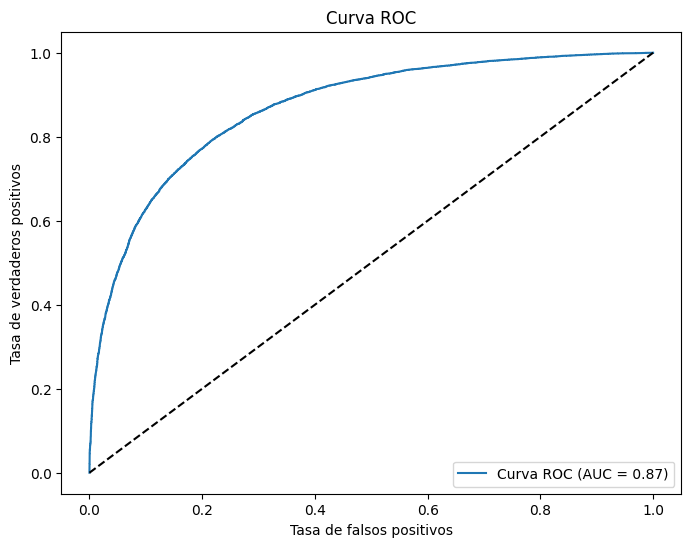

ROC-AUC: 0.916


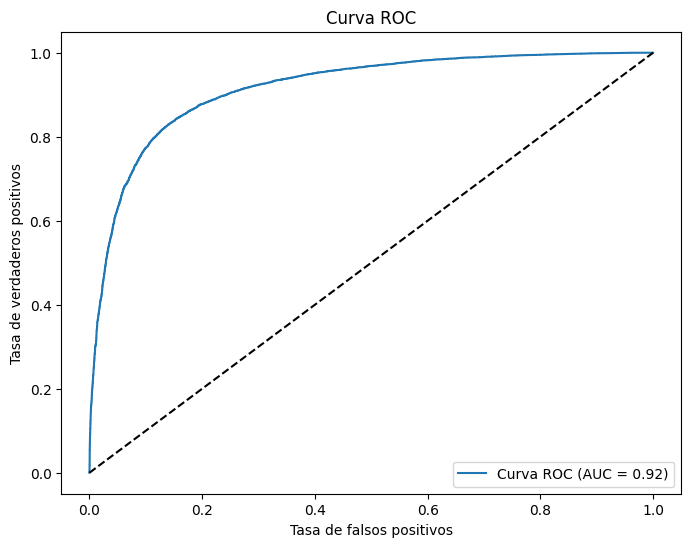

In [40]:
curva_roc(y_gru_pred, y_test)
curva_roc(y_lstm_pred, y_test)

#### Visualiza los errores

In [46]:
#y_gru_pred = gru_model.predict(x_test)
# Convierte las probabilidades a etiquetas binarias usando un umbral de 0.5
y_pred = (y_gru_pred > 0.5).astype("int32").flatten()

# Identificar los índices mal clasificados
misclassified_idx = np.where(y_pred != y_test)[0]
print("Número de ejemplos mal clasificados:", len(misclassified_idx))

if len(misclassified_idx) > 0:
    # Seleccionamos el primer ejemplo mal clasificado
    idx = misclassified_idx[1]
    print(f"\nEjemplo mal clasificado en el índice {idx}:")
    print("Etiqueta real:", y_test[idx])
    print("Predicción:", y_pred[idx])
    
    # Mostrar la secuencia (como números)
    #print("\nSecuencia (token IDs):")
    #print(x_test[idx])
 # Si deseas visualizar la reseña en texto, es necesario decodificar la secuencia.
    # Para ello, construimos el diccionario inverso:
    word_index = imdb.get_word_index()
    # El dataset de IMDb reserva índices 0, 1 y 2 para padding, inicio de secuencia y desconocidos.
    reverse_word_index = {value: key for key, value in word_index.items()}
    
    def decode_review(sequence):
        # Se resta 3 a cada índice para compensar los tokens reservados.
        return ' '.join([reverse_word_index.get(i - 3, '?') for i in sequence if i >= 3])
    
    review_text = decode_review(x_test[idx])
    print("\nReseña decodificada:")
    print(review_text)
else:
    print("No se encontraron ejemplos mal clasificados.")

Número de ejemplos mal clasificados: 5753

Ejemplo mal clasificado en el índice 3:
Etiqueta real: 0
Predicción: 1

Reseña decodificada:
i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are involved with the actions on 

#### Ejempo con BERT
Reentrenemos BERT con los datos de reseñas de IMDB

In [6]:
print(x_train.dtype) 
print(y_train.dtype) 
print(x_test.dtype) 
print(y_test.dtype) 


int32
int64
int32
int64


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb

In [ ]:
max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Let's take a look at what the review is like!
print("First review:")
print(x_train)

print("\nFirst review label:")
print(y_train)


In [27]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [28]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Cargar modelo preentrenado
modelo = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
#modelo = TFBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2) 
# Convertir etiquetas en tensores
train_labels = tf.convert_to_tensor(y_train, dtype=tf.int32)
test_labels = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Compilar el modelo
modelo.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #loss=ttf.compat.v1.losses.sparse_softmax_cross_entropy(labels, logits, weights=1.0, scope=None, loss_collection=ops.GraphKeys.LOSSES, reduction=Reduction.SUM_BY_NONZERO_WEIGHTS),
    metrics=["accuracy"]
)


# Entrenar el modelo con batch_size de 1000
#modelo.fit(x_train, y_train, epochs=3, batch_size=1000, validation_data=(x_test, y_test))
#modelo.fit(x_train, train_labels, epochs=1, batch_size=100)
# Evaluar el modelo
#modelo.evaluate(x_test, test_labels)
x_train_reducido = x_train[:500]
y_train_reducido = y_train[:500]

#modelo.fit(x_train_reducido, y_train_reducido, epochs=1, batch_size=32, validation_data=(x_test, y_test))


modelo.fit(x_train_reducido, y_train_reducido, epochs=1, batch_size=8)


salida_pred = modelo.predict(x_test, batch_size=8)
y_pred = tf.nn.softmax(salida_pred.logits).numpy()
y_pred_labels = np.argmax(y_pred, axis=1)  # Convertir a etiquetas (0 o 1)


OSError: El archivo de paginación es demasiado pequeño para completar la operación. (os error 1455)

In [ ]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Cargar modelo preentrenado
modelo = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Compilar el modelo con un optimizador adecuado
modelo.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


modelo.fit(x_train, y_train, epochs=3, batch_size=8, validation_data=(x_test, y_test))


loss, accuracy = modelo.evaluate(x_test, y_test)
print(f"Pérdida: {loss:.4f}, Precisión: {accuracy:.4f}")

modelo.save_pretrained("./modelo_bert_sentimiento")

import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Generar predicciones con el modelo usando `x_test`
salida_pred = modelo.predict(x_test)

# Convertir logits en probabilidades y etiquetas predichas
y_pred = tf.nn.softmax(salida_pred.logits).numpy()  # Aplicar softmax para obtener probabilidades
y_pred_labels = np.argmax(y_pred, axis=1)  # Convertir a etiquetas (0 o 1)

